In [11]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, DivergingNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

# import pandas as pd
import xarray as xr
from scipy import signal, integrate

# import xrft
# import warnings
# warnings.warn('ignore', FutureWarning)
# warnings.simplefilter(action='ignore', category=FutureWarning)

from subroutines import *
from vis_eulag import *

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

CLEV_100 = np.array([-100,-50,-20,-10,-7,-5,-3,-1,1,3,5,7,10,20,50,100])
CLEV_100_LABELS = np.array([-50,-10,-5,-1,1,5,10,50])

CLEV_30 = [-30,-10,-7,-5,-3,-2,-1,-0.5,0.5,1,2,3,5,7,10,30]
CLEV_30_LABELS = [-10,-5,-2,-0.5,0.5,2,5,10]

# CLEV_20 = [-20.,-7.,-5.,-3.,-2.,-1.,-0.7,-0.5,-0.2,-0.1,0.1,0.2,0.5,0.7,1.,2.,3.,5.,7.,20.]

CLEV_10 = np.array([-10.,-5.,-2.,-1.,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,1.,2.,5.,10.])
CLEV_10_LABELS = np.array([-5.,-1.,-0.5,-0.1,0.1,0.5,1.,5.])

CLEV_5 = [-5.,-2.,-1.,-0.7,-0.5,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.5,0.7,1.,2.,5.]
CLEV_5_LABELS = [-2.,-0.7,-0.3,-0.1,0.1,0.3,0.7,2.]

CLEV_2 = [-2.,-1.,-0.5,-0.3,-0.2,-0.1,-0.07,-0.05,0.05,0.07,0.1,0.2,0.3,0.5,1.,2.]
CLEV_2_LABELS = [-1.,-0.3,-0.1,-0.05,0.05,0.1,0.3,1.]

CLEV_05 = [-0.5,-0.3,-0.1,-0.05,-0.03,-0.01,-0.005,-0.002,0.002,0.005,0.01,0.03,0.05,0.1,0.3,0.5]
CLEV_05_LABELS = [-0.3,-0.05,-0.01,-0.002,0.002,0.01,0.05,0.3]

CLEV_01 = CLEV_100/1000
CLEV_01_LABELS = CLEV_100_LABELS/1000

plt.style.use('latex_default.mplstyle')

In [17]:
SETTINGS = load_settings('settings_local_inGrav.txt')
fileLocations = ['/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_005a', '/work/bd0620/b309199/inGrav3D_GWD/inGrav3D_009a']

ds_list = []
for fileLocation in fileLocations:
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap

    ds.attrs['cp'] = np.round(ds.attrs['cp'],3) # .round(3)
    ds.attrs['cap'] = np.round(ds.attrs['cap'])
    ds.attrs['capp'] = np.round(ds.attrs['capp'])
    ds.attrs['compri'] = np.round(ds.attrs['compri'])
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    # ds['pprime']=ds['p'] # h12
    ds['pprime']=filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)

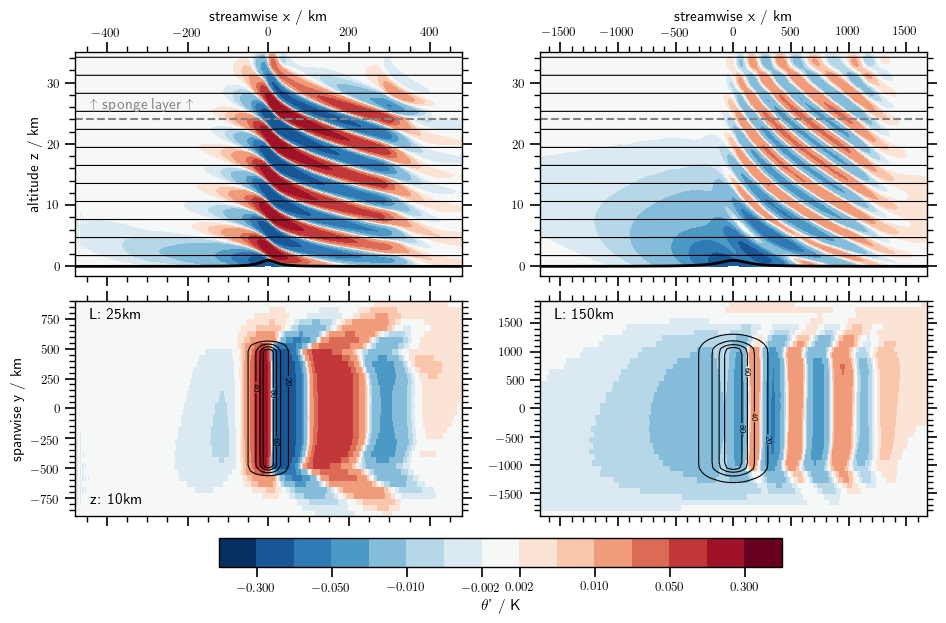

In [31]:
# gskw = {'hspace':0.07}
gskw = {'hspace':0.1, 'wspace':0.2, 'height_ratios': [6,7.5], 'width_ratios': [5,5]}
fig, axes = plt.subplots(2,2,figsize=(11,7), gridspec_kw=gskw)
# ((ax0,ax1,ax2),(ax3,ax4,ax5))

z=200
z_l = 10 # km

cmap = plt.get_cmap('RdBu_r')

ZLIM = [-1.5,35]
YLIM = [-1900,1900]

t=6
for j in range(0,2):
    ds = ds_list[j]
    y=int(ds.ny/2)
    
    if j==1:
        clev = CLEV_05
        clev_l = CLEV_05_LABELS
    else:
        clev = CLEV_05
        clev_l = CLEV_05
    norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)    
    
    i=0 # vertical cross-section
    pcMesh0 = axes[i,j].pcolormesh(ds.xcr[y], ds.zcr[t,:,y,:], ds.th[t,:,y,:],
                                cmap=cmap, norm=norm, shading='nearest')
    # time_label = 'T' + str(t*12) + 'h'
    # axes[i].set_title(time_label, weight='bold',size=12,pad=10)
    axes[i,j] = format_xz_plot(ds, SETTINGS, axes[i,j], t, y=y)
    # axes[i,j].set_aspect(0.66)
    
    if j==0:
        axes[i,j].set_ylabel(r'altitude z / km')
    axes[i,j].xaxis.set_label_position('top')
    axes[i,j].tick_params(labeltop=True, labelbottom=False)
    axes[i,j].set_xlabel('streamwise x / km')
    
    axes[i,j].set_ylim(ZLIM)
        
    i=1 # horizontal cross-section
    pcMesh = axes[i,j].pcolormesh(ds.xcr, ds.ycr, ds.th[t,z,:,:],
                                     cmap=cmap, norm=norm, shading='nearest')
    axes[i,j] = format_xy_plot(ds, SETTINGS, axes[i,j], t, z=z)
    # axes[i].axis('scaled')

    # axes[i,j].set_aspect(0.66)
    axes[i,j].tick_params(labelbottom=False)
    if j==0:
        axes[i,j].set_ylabel('spanwise y / km')
    if j==1:
        axes[i,j].set_ylim(YLIM)
    else:
        axes[i,j].set_ylim([-900,900])
    
axes[1,0].text(0.04,0.06, 'z: 10km', transform=axes[1,0].transAxes, weight='bold')
axes[1,0].text(0.04,0.92, 'L: 25km',  transform=axes[1,0].transAxes, weight='bold')
axes[1,1].text(0.04,0.92, 'L: 150km', transform=axes[1,1].transAxes, weight='bold')
# axes[0,1].tick_params(labelleft=False)

# - SPONGE LAYER - #
lw_sponge = 1.5
h_sponge = 24
axes[0,0].axhline(y=h_sponge, xmin=0, xmax=1, lw=lw_sponge,ls='--',color='grey')
axes[0,1].axhline(y=h_sponge, xmin=0, xmax=1, lw=lw_sponge,ls='--',color='grey')
sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
axes[0,0].text(0.04, 0.75, sponge_label, transform=axes[0,0].transAxes, color='grey')


    
# axes[0,0].set_xlim([4500,13000])
cbar = fig.colorbar(pcMesh, ax=axes[1,:], location='bottom', ticks=clev_l, pad=0.08, shrink=0.66)
cbar.set_label(r"$\theta$' / K")
cbar.formatter.set_powerlimits((0, 0))

# cbar.ax.tick_params(labelsize=9)

# --- Save figure --- #
# fig.suptitle(title_label)
fig_name = 'th-xz-xy_inGrav.png'
fig.tight_layout()
fig.savefig('../figures/' + fig_name, facecolor='w', edgecolor='w',
                format='png', dpi=150)

In [4]:
######################